### Import Modules and Download Data

In [181]:
import re
import requests
from io import StringIO
import pandas as pd
import nltk
from nltk.stem.porter import PorterStemmer
import gensim
from gensim import models, corpora, similarities
from gensim.models import CoherenceModel
from nltk import FreqDist
import numpy as np
from scipy.stats import entropy
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

pd.set_option('display.max_colwidth', None)

In [5]:
url_data = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vTxbA16lnYbtH-j6PPrPogc6ft03gp0y5mmo1Nq3l-Pxnb05nP1C-mOxUYvTciA2gq5nkwAqz9Y7Imi/pub?gid=646892609&single=true&output=tsv'

In [6]:
def load_dataset(url):
    r = requests.get(url)
    data = r.content.decode('utf8')
    df = pd.read_csv(StringIO(data), sep='\t')
    return df

In [7]:
df = load_dataset(url_data)

### Inspect the Dataset

In [8]:
df.head(15)

,name,description,country,founding_date,relevancy
0,Pandora Car Rental,"Welcome to Pandora Car Rental, Car Hire and Airport Transfers based in Dalaman Turkey. We have a wide range of cars to suit all budgets and can deliver your car for free anytime day or night within the Dalaman locality. Reasons to Book Car from Pandora Car Rental: Unlimited Milage VAT All Local Taxes Airport Service Charge where applicable 24 hours Road Service Third Party Insurance with NO Excess Theft Insurance with NO Excess Fire Insurance with NO Excess FDW Insurance with NO Excess CDW Collision Damage Waiver with NO Excess TWH Tyre Windscreen Headlight Insurance with NO Excess 3 Additional Drivers Child/Baby Seat (must be ordered) No Hidden Extras Address: Hadrian Flats Number 4 Wellington Telford Pin Code: TF11RQ Tel: + 44 776 558 66 77 Website: http://www.dalamancarrental.com",United Kingdom,2011-04-05,0
1,SurplusMatch,"SurplusMatch is an online marketplace for contractors, Merchants and Manufacturers to buy and sell old stocks, end of line, slight seconds and site surplus materials. Sellers list the details of stock, buyers browse and order the materials and SurplusMatch delivers them while maintaining the anonymity of the seller.",United Kingdom,2008-01-01,2
2,Gimenez Ganga,"Giménez Ganga is a company that has been providing solutions for windows, sunlight protection and decoration since 1959.",Switzerland,1959-01-01,0
3,SMC3,"Freight shippers, motor carriers, logistics service providers and other supply chain professionals look to SMC³ for the technology, industry data, educational services and general know-how to achieve greater success in the transportation marketplace. The company is best known for its CzarLite base rates, which are used as a price benchmark in transportation agreements. Additionally SMC³ produces a range of enabling technologies that give shippers and carriers complete visibility into their transportation spend. Each January and June, SMC³ hosts a comprehensive supply chain conference that gives industry professionals an inside look into cost-saving trends and best business practices as well as timely economic and legislative updates.",United States,1935-01-01,0
4,Much Asphalt,Much Asphalt is southern Africa’s commercial supplier of an extensive range of hot and cold asphalt products to the road construction economy. Much Asphalt owns and operates 15 static plants in the major centres of South Africa and is the majority shareholder in East Coast Asphalt which operates two more in East London and Mthatha.,South Africa,1965-01-01,0
5,The Hisey Company,"The Hisey Company provides quality arbor care for consumers, providing a professional grade of service far beyond anything available in the marketplace today. With a focus on professionalism and quality of customer service, the company has created a experience that every customer will be hard pressed to find with any other service company. In a industry with many """"competitors"""", we set ourselves apart by providing service far above and beyond our competitors very best. This is clearly evident in the growth and revenues that we have accomplished over the past 36 months. Without turning our focus away from continuing to grow, we aim to continue to build lasting relationships with every customer that will bring them back again.",United States,2011-02-19,0
6,"FREIGHTALIA, LTD.","#1 Automatic quoting system ever created for Freight Forwarders, fully adaptable to your clientele, country or service needs. With Freightalia you can send beautiful quotes to your customers in real time. Know exactly when a quote was issued, when it was viewed, when it was accepted, and when it’s still pending.",United Kingdom,2015-09-26,0
7,Instant Access Au,"Instant Access is a provider of Access equipment including aluminium scaffolding, mobile towers, Elevated Working Platform, swing stages and specialized access solutions tailored to specific customers. Instant Access were the first company in Aust

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   name           2000 non-null   object
 1   description    2000 non-null   object
 2   country        2000 non-null   object
 3   founding_date  2000 non-null   object
 4   relevancy      2000 non-null   int64 
dtypes: int64(1), object(4)
memory usage: 78.2+ KB


In [10]:
# Check for null values
df.isnull().values.any()

False

### Preprocess the Data

In [11]:
nltk.download('stopwords')
stopwords = nltk.corpus.stopwords.words('english')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [12]:
stemmer = PorterStemmer()

def pre_process(text):
    #websites, email and any punctuation cleaning
    text = re.sub("((\S+)?(http(s)?)(\S+))|((\S+)?(www)(\S+))|((\S+)?(\@)(\S+)?)", " ", text)
    text = re.sub("[^a-zA-Z ]", "", text)
    text = text.lower() # lower case the text
    text = nltk.word_tokenize(text)
    #removing stopwords
    text = [word for word in text if word not in stopwords]
    #stemming
    try:
        text = [stemmer.stem(word) for word in text]
        text = [word for word in text if len(word) > 1]
    except IndexError:
        pass   
    
    return " ".join(text)



### Tf-Idf Based Approach (Vector Space Modeling)

**1. Commend Each Cell**

In [13]:
# apply pre_process function, preprocess the description data (lower case, remove websites, email, punctuation and stopwords; stemming), 
# and vectorize the company descriptions using the method Tf-Idf
tfidf = TfidfVectorizer(preprocessor=pre_process).fit_transform(df.description)

In [14]:
# get the index of company 'Vahanalytics'
doc_index_to_compare = df.index[df['name'] == "Vahanalytics"].tolist()[0]
top_k = 5
# Calculate the cosine similarities between company 'Vahanalytics' and the other companies in the data
cosine_similarities = cosine_similarity(tfidf[doc_index_to_compare:doc_index_to_compare + 1], tfidf).flatten()

In [15]:
# sort the cosine similarities increasingly, and return the top 5 similary ones with indices
related_docs_indices = cosine_similarities.argsort()[:-top_k - 1:-1]

In [16]:
# get the top 5 companies by the indices
tfidf_result_df = df[df.index.isin(related_docs_indices)]

In [17]:
tfidf_result_df

,name,description,country,founding_date,relevancy
93,Ship Supplies Direct,We aim to use digital technology to transform the marine logistics industry,Singapore,2018-05-14,1
656,BISAF,"BISAF is a technological company for the construction industry. We specialise in cutting edge solutions that make building easier, safer and environmentally friendly.",United Kingdom,2006-05-01,1
695,Vahanalytics,Vahanalytics aims to create better drivers and safer roads by using cutting edge big data and machine learning techniques.,India,2016-01-01,1
1542,GeoSpock,"GeoSpock brings together their expertise of big data engineering to unlock the hidden value of data silos in your organization. Their solution enables you to manage extreme amounts of data at speed enabling your organization to react to key insights in a timely manner for future business success. The technology enables a range of capabilities from data analytics, visualization of spatial data, cutting edge data indexing, custom querying of data sets, and data intelligence. To ensure that their customers get the maximum impact using the GeoSpock solution they work with them on a one to one basis as they understand that each organization approaches their data problems in a bespoke manner, this ensures that you get maximum business impact. In bringing together multiple datasets this enables the cost of data generation to be amortized over many applications, opening up new business models and monetization opportunities, therefore, bringing value to your business. They work across a number of markets including smart cities, automotive, mobile networks, IoT, enterprise, AdTech, asset management, and logistics.",United Kingdom,2013-01-01,1
1982,Axenda,"Axenda is a cloud-based software platform for construction management industry. The software platform is used by constructors and architects to manage day-to-day tasks and grow their businesses. The company's patent-pending algorithm uses machine learning to estimate materials & resources. It aims to predict project's estimates & completion deadlines. In addition, the platform also translates the data into 3D virtual models which give visual feedback of project's progress to clients.",Mexico,2017-01-01,2


**2. Get the top 5 most similar companies to the company “Much Asphalt”**

In [18]:
# get the index of company 'Vahanalytics'
doc_index_to_compare = df.index[df['name'] == "Much Asphalt"].tolist()[0]
top_k = 5
# Calculate the cosine similarities between company 'Vahanalytics' and the other companies in the data
cosine_similarities = cosine_similarity(tfidf[doc_index_to_compare:doc_index_to_compare + 1], tfidf).flatten()

# sort the cosine similarities increasingly, and return the top 5 similary ones with indices
related_docs_indices = cosine_similarities.argsort()[:-top_k - 1:-1]

# get the top 5 companies by the indices
tfidf_result_df = df[df.index.isin(related_docs_indices)]

print("The top 5 similar companies to 'Much Asphalt:")
tfidf_result_df

The top 5 similar companies to 'Much Asphalt:


,name,description,country,founding_date,relevancy
4,Much Asphalt,Much Asphalt is southern Africa’s commercial supplier of an extensive range of hot and cold asphalt products to the road construction economy. Much Asphalt owns and operates 15 static plants in the major centres of South Africa and is the majority shareholder in East Coast Asphalt which operates two more in East London and Mthatha.,South Africa,1965-01-01,0
57,Sunland Asphalt,"Sunland Asphalt, a commercial asphalt paving company in Phoenix, provides commercial asphalt paving service at competitive price.",United States,1979-01-01,0
618,Central-Allied Enterprises,"Central States Construction was founded in 1929 by Ernest W. Hallett to produce sand and gravel and construct concrete highways in Minnesota. The business was successful, and in the early 1940s, operations expanded to western Ohio. In the 1940s, the company was heavily involved in the wartime expansion of Wright-Patterson Air Force Base and the post-war construction of the Ohio Turnpike. By the early 1950s, Ohio operations had expanded to include production of sand, gravel, asphalt, and concrete. The Ohio-based portion of the business became known as Allied Enterprises, and it made its permanent presence in Northeastern Ohio by the end of the 50s. Today, Central-Allied Enterprises is one of northeastern Ohio's leading producers of sand, gravel, asphalt, and paved asphalt surfaces.",United States,1929-01-01,0
862,FAST FELT,"The patented product FAST FELT®, with its plastic tabs pre-affixed to the asphalt saturated felt (commonly called ""tar paper"") is the only significant improvement in the recent history of the asphalt saturated felt underlayment products market.",United States,2007-01-01,0
1443,Saldus Celinieks,"Saldus Celinieks is specialising in road construction, extraction of aggregates and asphalt production.",Latvia,1991-01-01,1


## Topic Modeling Using LDA
Find the top 5 closest matches (companies) to the companies with names:

● “Much Asphalt”

● “Vahanalytics”


**1. Preprocess and tokenize the descriptions**

In [20]:
# preprocess the data by pre_process function(remove website, email, stop words etc. from descriptions, and stem words)
# put the preprocessed description in a new column 'description_no_stopwords'
df['description_no_stopwords'] = [pre_process(des) for des in df['description']]

In [21]:
# tokenize the non-stopwords descriptions and create a new column 'tokenized'
def sent_to_words(df, column='description_no_stopwords'):
    for sentence in df[column]:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True)) 
df['tokenized'] = list(sent_to_words(df))

df.head(3)

,name,description,country,founding_date,relevancy,description_no_stopwords,tokenized
0,Pandora Car Rental,"Welcome to Pandora Car Rental, Car Hire and Airport Transfers based in Dalaman Turkey. We have a wide range of cars to suit all budgets and can deliver your car for free anytime day or night within the Dalaman locality. Reasons to Book Car from Pandora Car Rental: Unlimited Milage VAT All Local Taxes Airport Service Charge where applicable 24 hours Road Service Third Party Insurance with NO Excess Theft Insurance with NO Excess Fire Insurance with NO Excess FDW Insurance with NO Excess CDW Collision Damage Waiver with NO Excess TWH Tyre Windscreen Headlight Insurance with NO Excess 3 Additional Drivers Child/Baby Seat (must be ordered) No Hidden Extras Address: Hadrian Flats Number 4 Wellington Telford Pin Code: TF11RQ Tel: + 44 776 558 66 77 Website: http://www.dalamancarrental.com",United Kingdom,2011-04-05,0,welcom pandora car rental car hire airport transfer base dalaman turkey wide rang car suit budget deliv car free anytim day night within dalaman local reason book car pandora car rental unlimit milag vat local tax airport servic charg applic hour road servic third parti insur excess theft insur excess fire insur excess fdw insur excess cdw collis damag waiver excess twh tyre windscreen headlight insur excess addit driver childbabi seat must order hidden extra address hadrian flat number wellington telford pin code tfrq tel websit,"[welcom, pandora, car, rental, car, hire, airport, transfer, base, dalaman, turkey, wide, rang, car, suit, budget, deliv, car, free, anytim, day, night, within, dalaman, local, reason, book, car, pandora, car, rental, unlimit, milag, vat, local, tax, airport, servic, charg, applic, hour, road, servic, third, parti, insur, excess, theft, insur, excess, fire, insur, excess, fdw, insur, excess, cdw, collis, damag, waiver, excess, twh, tyre, windscreen, headlight, insur, excess, addit, driver, childbabi, seat, must, order, hidden, extra, address, hadrian, flat, number, wellington, telford, pin, code, tfrq, tel, websit]"
1,SurplusMatch,"SurplusMatch is an online marketplace for contractors, Merchants and Manufacturers to buy and sell old stocks, end of line, slight seconds and site surplus materials. Sellers list the details of stock, buyers browse and order the materials and SurplusMatch delivers them while maintaining the anonymity of the seller.",United Kingdom,2008-01-01,2,surplusmatch onlin marketplac contractor merchant manufactur buy sell old stock end line slight second site surplu materi seller list detail stock buyer brows order materi surplusmatch deliv maintain anonym seller,"[surplusmatch, onlin, marketplac, contractor, merchant, manufactur, buy, sell, old, stock, end, line, slight, second, site, surplu, materi, seller, list, detail, stock, buyer, brows, order, materi, surplusmatch, deliv, maintain, anonym, seller]"
2,Gimenez Ganga,"Giménez Ganga is a company that has been providing solutions for windows, sunlight protection and decoration since 1959.",Switzerland,1959-01-01,0,gimnez ganga compani provid solut window sunlight protect decor sinc,"[gimnez, ganga, compani, provid, solut, window, sunlight, protect, decor, sinc]"


**2. Find top 5000 common tokens and remove uncommon tokens from the column 'tokenized'**

In [25]:
# Using this new column 'tokenized', find the 5000 most common tokens.
# Remove all tokens that are not in the 5000 most common tokens from the column tokenized.
def find_common_tokens(df,column='tokenized',top=5000):
  """find the top common tokens in the data."""
  word_dict = {}
  for wordlist in df[column]:
    for w in wordlist:
      if w not in word_dict:
        word_dict[w] = 1
      else:
        word_dict[w] += 1 
  # sort the token dictionary by word counts
  word_dict = {k: v for k, v in sorted(word_dict.items(), key=lambda item: item[1])}
  common_tokens = list(word_dict.keys())[-1*top:]
  #print(common_tokens[-5000:])
  return  common_tokens

def remove_uncommon_tokens(df,common_tokens,column='tokenized'):
  """remove tokens that are not in the 5000 common tokens"""
  cleaned_tokens = []
  for wordlist in df[column]:
    temp = []
    for w in wordlist:
      if w in common_tokens:
        temp.append(w)
    cleaned_tokens.append(temp)

  df[column] = cleaned_tokens

  return df

  
# get the top 5000 common tokens
common_tokens = find_common_tokens(df)

# remove tokens that are not in the top 5000 common tokens from the column 'tokenized'
df = remove_uncommon_tokens(df, common_tokens)



**3. Create corpus and id2word dictionary for topic modeling**

In [34]:
# create corpus and dictionary for topic modeling
# Create Dictionary
id2word = corpora.Dictionary(df['tokenized'])

# Create Corpus
texts = df['tokenized']

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[0:1])

[[(0, 1), (1, 1), (2, 2), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 6), (9, 1), (10, 1), (11, 1), (12, 2), (13, 1), (14, 1), (15, 1), (16, 1), (17, 6), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 5), (28, 2), (29, 1), (30, 1), (31, 1), (32, 1), (33, 2), (34, 1), (35, 1), (36, 1), (37, 1), (38, 2), (39, 1), (40, 1), (41, 2), (42, 1), (43, 1), (44, 1), (45, 1), (46, 1), (47, 1), (48, 1), (49, 1), (50, 1), (51, 1), (52, 1), (53, 1), (54, 1), (55, 1), (56, 1)]]


In [35]:
# index to word
id2word[0]

'addit'

In [36]:
# words and their counts in the first company description
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('addit', 1),
  ('address', 1),
  ('airport', 2),
  ('anytim', 1),
  ('applic', 1),
  ('base', 1),
  ('book', 1),
  ('budget', 1),
  ('car', 6),
  ('charg', 1),
  ('code', 1),
  ('collis', 1),
  ('dalaman', 2),
  ('damag', 1),
  ('day', 1),
  ('deliv', 1),
  ('driver', 1),
  ('excess', 6),
  ('extra', 1),
  ('fire', 1),
  ('flat', 1),
  ('free', 1),
  ('hadrian', 1),
  ('headlight', 1),
  ('hidden', 1),
  ('hire', 1),
  ('hour', 1),
  ('insur', 5),
  ('local', 2),
  ('must', 1),
  ('night', 1),
  ('number', 1),
  ('order', 1),
  ('pandora', 2),
  ('parti', 1),
  ('pin', 1),
  ('rang', 1),
  ('reason', 1),
  ('rental', 2),
  ('road', 1),
  ('seat', 1),
  ('servic', 2),
  ('suit', 1),
  ('tax', 1),
  ('tel', 1),
  ('theft', 1),
  ('third', 1),
  ('transfer', 1),
  ('turkey', 1),
  ('tyre', 1),
  ('unlimit', 1),
  ('vat', 1),
  ('waiver', 1),
  ('websit', 1),
  ('welcom', 1),
  ('wide', 1),
  ('within', 1)]]

**4. Train models with different num_topics**

In [44]:
def compute_coherence_values(id2word, corpus, texts, limit=100, start=2, step=3):
    """Compute coherence for various number of topics"""
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [46]:
model_list, coherence_values = compute_coherence_values(id2word, corpus, texts, limit=100)

**5. Show the training results, plot and print the num_topics and the corresponding coherence scores**

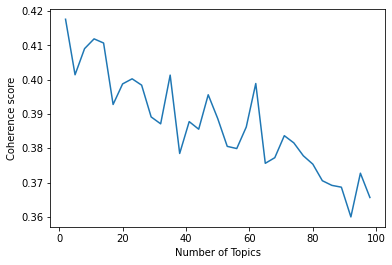

In [194]:
x = range(2, 100, 3)
plt.plot(x, coherence_values)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence score")
#plt.legend(("coherence_values"), loc='best')
plt.show()

In [195]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, ", Coherence Value =", round(cv, 4))

Num Topics = 2 , Coherence Value = 0.4176
Num Topics = 5 , Coherence Value = 0.4014
Num Topics = 8 , Coherence Value = 0.409
Num Topics = 11 , Coherence Value = 0.4119
Num Topics = 14 , Coherence Value = 0.4106
Num Topics = 17 , Coherence Value = 0.3927
Num Topics = 20 , Coherence Value = 0.3987
Num Topics = 23 , Coherence Value = 0.4002
Num Topics = 26 , Coherence Value = 0.3984
Num Topics = 29 , Coherence Value = 0.3891
Num Topics = 32 , Coherence Value = 0.3871
Num Topics = 35 , Coherence Value = 0.4013
Num Topics = 38 , Coherence Value = 0.3785
Num Topics = 41 , Coherence Value = 0.3877
Num Topics = 44 , Coherence Value = 0.3855
Num Topics = 47 , Coherence Value = 0.3956
Num Topics = 50 , Coherence Value = 0.3886
Num Topics = 53 , Coherence Value = 0.3805
Num Topics = 56 , Coherence Value = 0.3799
Num Topics = 59 , Coherence Value = 0.3862
Num Topics = 62 , Coherence Value = 0.3988
Num Topics = 65 , Coherence Value = 0.3756
Num Topics = 68 , Coherence Value = 0.3772
Num Topics = 71

**6. Choose the model with best coherence score and get the lda output**

In [190]:
num_topics = 2
model = model_list[0]

# get the lda output of corpus
lda_output = model[corpus]

In [197]:
model.show_topics()

[(0,
  '0.016*"servic" + 0.015*"compani" + 0.011*"provid" + 0.010*"construct" + 0.009*"manag" + 0.009*"product" + 0.009*"industri" + 0.008*"solut" + 0.006*"offer" + 0.006*"custom"'),
 (1,
  '0.017*"servic" + 0.014*"provid" + 0.012*"compani" + 0.011*"construct" + 0.010*"manag" + 0.009*"custom" + 0.009*"logist" + 0.009*"project" + 0.008*"product" + 0.007*"solut"')]

In [191]:
lda_output[5]

[(0, 0.48288637), (1, 0.5171136)]

**7. Handle the lda output, convert it to 2D array**

In [192]:
# convert LDA-results to 2D array
def convert_lda_output(lda_output):
  converted = np.empty([2000,2])
  for i in range(0, len(lda_output)):
    result = []
    for j in lda_output[i]:
      result.append(j[1])
    result = np.array(result)
    #converted.append(result)
    converted[i] = result
  #return np.array(converted)
  return converted

# get the lda output matrix
lda_output_matrix = convert_lda_output(lda_output)

**8. Top 5 closest companies to 'Much Asphalt'**

In [174]:
def jensen_shannon(query, matrix):
    p = query[None,:].T + np.zeros([num_topics, num_documents])  # 2*2000
    q = matrix.T
    m = 0.5*(p + q)
    return np.sqrt(0.5*(entropy(p,m) + entropy(q,m)))

def get_top_k_similar_docs(query, matrix, k=5):
    """Get the <k> most similar documents (represented by <matrix>) given a <query>.

    Args:
        query: 1D array
        matrix: 2D array
        k: int
    """
    sims = jensen_shannon(query,matrix)
    return sims.argsort()[:k]

In [67]:
# get the number of descriptions
num_documents = len(df)
num_documents

2000

In [179]:
# get the index of company “Much Asphalt”
index_ma = df.index[df['name']=="Much Asphalt"].tolist()[0]

# get the lda output of the company “Much Asphalt”
ma_lda_output = lda_output_matrix[index_ma]

# get top 5 closest companies indices
closest_company_indices = get_top_k_similar_docs(ma_lda_output, lda_output_matrix)

# get the companies info
df.iloc[closest_company_indices][['name', 'description']]

,name,description
4,Much Asphalt,Much Asphalt is southern Africa’s commercial supplier of an extensive range of hot and cold asphalt products to the road construction economy. Much Asphalt owns and operates 15 static plants in the major centres of South Africa and is the majority shareholder in East Coast Asphalt which operates two more in East London and Mthatha.
1668,I Believe,"I Believe is an e-commerce, logistics and convenience store franchise operator. Unlike traditional convenience stores, the company sources goods directly from manufacturers and provides online order placements, reducing the layer of purchases from whole-sellers."
119,PrinetZ,PrinetZ is a Basic design and detailed design are as important as software development design for server design.
1039,OIA GLOBAL,"Since they began operations in 1988, OIA has grown, expanded capabilities and global reach, and adapted services to become a leading, and truly original supply chain management company. Their service offering of Materials, Packaging, and Logistics makes OIA the most unique provider out there. Still, we believe it’s their dedicated staff of the industry’s best professionals that makes the difference. With deep roots in innovation and a customer-first mentality, they make a large impact for their clients."
1925,Ainsworth Benning Construction,"Ainsworth-Benning is a premier commercial general contractor serving South Dakota, Wyoming, North Dakota, Montana and Nebraska for over 55 years. Our company’s greatest assets are our clients and our people."


**9. Top 5 Closest companies to 'Vahanalytics'**

In [180]:
# get the index of the company “Vahanalytics”
index_va = df.index[df['name']=="Vahanalytics"].tolist()[0]

# get the lda output of the company “Vahanalytics”
va_lda_output = lda_output_matrix[index_va]

# get the index of the top 5 closest companies of “Vahanalytics”
closest_company_indices = get_top_k_similar_docs(va_lda_output, lda_output_matrix)

# get the companies info
df.iloc[closest_company_indices][['name', 'description']]

,name,description
695,Vahanalytics,Vahanalytics aims to create better drivers and safer roads by using cutting edge big data and machine learning techniques.
392,Transported,"Transported is a platform for real estate to create virtual reality walkthroughs. Users can upload footage from VR cameras and add details. It pulls in MLS data and claims that with a single click, walkthroughs are available on various VR platforms like Oculus, Vive, Daydream, PSVR, GearVR, and the web. Claims to enable real estate agents to create VR tours in less than 10 minutes as well as place a VR headset in office. Yet to launch as of Dec 2016, still in beta."
599,Retco Sp. z o. o.,"Retco is an independent platform providing complex ecommerce solutions for all types of partners. We offer a cost-effective end-to-end service for shipping and excellent returns solution. We also design processes with our partners and adjust to nonstandard needs. Our central location is in Poland. Our expertise covers all countries within Central and Eastern Europe. Obviously, we also offer service in other countries."
1042,catkin,catkin is a web-based portal for cross-company and cross-system communication.
1650,Sobim,Sobim is offering training on BIM.
